In [1]:
from tqdm.auto import tqdm
import torch 
import transformers
from transformers import PreTrainedTokenizer
from transformers import RobertaTokenizer, RobertaConfig, RobertaModel, RobertaForTokenClassification
#from sentence_transformers import SentenceTransformer, SentencesDataset, InputExample, losses, util
from datasets import Dataset
import pandas as pd
from transformers.optimization import get_linear_schedule_with_warmup
#import matplotlib.pyplot as plt 
import numpy as np
from transformers import AutoTokenizer, AutoModel, PreTrainedTokenizerFast, RobertaTokenizerFast
#from torch.nn import CosineEmbeddingLoss
import random
#from torch.nn import CosineEmbeddingLoss
from torch import nn
#Build up to SBERT model 

In [2]:
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from torch.utils.data import DataLoader,random_split,SubsetRandomSampler

In [3]:
#df = pd.read_csv("/shared/3/projects/benlitterer/podcastData/hostIdentification/itunesGTsubset.tsv", sep="\t") 

In [4]:
df = pd.read_json("/shared/3/projects/benlitterer/podcastData/annotation/label1000/MACE/1000annotTrain.jsonl", orient="records", lines=True)

In [5]:
#set seeds
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [6]:
df["entSnippets"] = df["left"] + df["ent"] + df["right"] 

In [7]:
df = df[["left", "right", "ent",'transStarts', 'transEnds', 'groundTruth', 'entSnippets']]
df = df.dropna()

In [8]:
#when we make the snippet, our spacing from the named entity extraction gets thrown off
#that's fine though! just re-extract the entity indices here 
df["snippetStart"] = df.apply(lambda x: x["entSnippets"].lower().find(x["ent"].lower()), axis=1)
df["snippetEnd"] = df["snippetStart"] + df["transEnds"] - df["transStarts"]


def extractEnt(inRow): 
    return inRow["entSnippets"][inRow["snippetStart"]:inRow["snippetEnd"]]

df["extractedEnt"] = df.apply(extractEnt, axis=1)

In [9]:
deviceNum = 0
device = torch.device("cuda:" + str(deviceNum) if torch.cuda.is_available() else "cpu")

In [10]:
df = df.reset_index(drop=True)

In [11]:
print(device)

cuda:0


In [12]:

#put ground truth values into a list 
#trainDf = trainDf[["entSnippets", "groundTruth", "snippetStart", "snippetEnd"]] 
#trainDf = trainDf.reset_index(drop=True)

#valDf = valDf[["entSnippets", "groundTruth", "snippetStart", "snippetEnd"]] 
#valDf = valDf.reset_index(drop=True)

#get train, valid, test 
#trainDf, testDf = train_test_split(leanDf, test_size=0.3) 
#validDf, testDf = train_test_split(testDf, test_size=0.666) 


#validDataset = Dataset.from_pandas(valDf)
#testDataset = Datase|t.from_pandas(testDf)

In [13]:
# Preprocessing
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base', max_length=512, padding="max_length", truncation=True)

In [14]:
tokenized = []
for snip in df["entSnippets"]: 
    tokenized.append(tokenizer(snip, padding = "max_length", truncation=True, return_offsets_mapping=True))

In [15]:
df = pd.concat([df, pd.DataFrame.from_records(tokenized)], axis=1) 

In [16]:
#find the token indices which correspond to our entity 
def getTokenIndices(start, end, offsets):
    """
    print(start) 
    print(end) 
    print(offsets[:20]) 
    """

    currIndices = []
    for j, offset in enumerate(offsets): 
        offsetL, offsetR = offset
        if offsetL >= start and offsetR <= end: 
            currIndices.append(j)

    return currIndices

In [17]:

df["posTokens"] = df.apply(lambda row: getTokenIndices(row["snippetStart"], row["snippetEnd"], row["offset_mapping"]), axis=1)

labList = []
for i, row in df.iterrows(): 
    tokCount = sum(row["attention_mask"])
    paddingLen = len(row["attention_mask"]) - tokCount
    
    labels = ([0] * tokCount) + ([2] * paddingLen)
    
    for posIndex in row["posTokens"]: 
        labels[posIndex] = 1
    
    labList.append(labels) 

df["labels"] = labList

df["entsTokenized"] = df.apply(lambda row: [tokenizer.decode(row["input_ids"][i]) for i in row["posTokens"]], axis=1) 

2024-05-15 13:55:23.191419: I tensorflow/core/platform/cpu_feature_guard.cc:181] Beginning TensorFlow 2.15, this package will be updated to install stock TensorFlow 2.15 alongside Intel's TensorFlow CPU extension plugin, which provides all the optimizations available in the package and more. If a compatible version of stock TensorFlow is present, only the extension will get installed. No changes to code or installation setup is needed as a result of this change.
More information on Intel's optimizations for TensorFlow, delivered as TensorFlow extension plugin can be viewed at https://github.com/intel/intel-extension-for-tensorflow.
2024-05-15 13:55:23.191476: I tensorflow/core/platform/cpu_feature_guard.cc:192] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
#TODO: check what that <s> token is... 
#sanity check looks good!
#df.sample(10)

In [19]:
#validDataset.set_format(type='torch', columns=["entSnippets", "groundTruth", "input_ids", "snippetStart", "snippetEnd", "attention_mask", "offset_mapping"])

In [20]:
class Model(nn.Module):
    def __init__(self, ixList):
        #def __init__(self):
        super(Model,self).__init__()
        self.model = RobertaModel.from_pretrained('roberta-base')

        #since we have three classes 
        self.l1 = nn.Linear(768, 3)

        #normalizes probabilities to sum to 1
        self.sig = nn.Sigmoid()
        self.ixList = ixList
        
    def mean_pooling(self, token_embeddings, attention_mask): 
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    
    def forward(self, input_ids, attention_mask, index): 
        
        #encode sentence and get mean pooled sentence representation 
        output = self.model(input_ids, attention_mask=attention_mask)
        
        #TODO: address problem that may be arising here 
        outIndices = [self.ixList[ix] for ix in index]
        embeddingMeans = []
        batchIter = 0
        for batchIter in range(input_ids.shape[0]): 
            
            #get the last layer of the model 
            hiddenStates = output[0]
            
            #get the embeddings corresponding to the entity we're interested in 
            tokStates = [hiddenStates[batchIter][tokIndex,:] for tokIndex in outIndices[batchIter]]
            
            #take the mean over all embeddings for an entity 
            embeddingMean = torch.stack(tokStates).mean(dim=0)
            
            #append this so we get the mean embedding for each 
            #training example in this batch 
            embeddingMeans.append(embeddingMean) 
            #embeddingMeans.append(hiddenStates[batchIter][outIndices[batchIter][0],:])
        
        #we stack because this is for an entire batch 
        embeddingMeans = torch.stack(embeddingMeans)
        """
        working code just used this!
        embeddingMeans = self.mean_pooling(output[0], attention_mask)
        """
        probs = self.sig(self.l1(embeddingMeans)).squeeze()
        
        return probs

In [21]:

#validation function 
def validate(model, validLoader, loss_func, f1type="weighted"):
    model.eval()
    
    validPreds = []
    validGts = []
    validLoss = []
    outList = [[], []]
    for batch in tqdm(validLoader): 
        
        optim.zero_grad()
        
        input_ids = batch["input_ids"].to(device) 
        attention_mask = batch["attention_mask"].to(device) 
        index = batch["index"]
        
        gt = batch["groundTruth"].to(device) #.to(torch.float32)
        probs = model(input_ids, attention_mask, index) #.to(torch.float32)
        
        
        #if we've hit the end of data, we may have a batch size of 1, which requires extra care
        if probs.size()[0] == 3 and len(probs.size()) == 1: 
            probs = probs.unsqueeze(0)
            print(probs.size())
            print(gt.size())

        loss = loss_func(probs, gt) 
        preds = torch.max(probs, 1).indices.to(int).cpu().tolist()
        gt = gt.to(int).detach().cpu().tolist()

        #update the lists of predictions, ground truths for train metrics
        validPreds += preds
        validGts += gt
        validLoss.append(loss.cpu().detach().item())

        
    
    f1 = f1_score(validPreds, validGts, average=f1type)
    validLossMean = np.mean(validLoss)
    
    model.train()
    return [validPreds, validGts, f1, validLossMean]
    
    
   


In [22]:
def train(model, fold, epochs, optim, scheduler, loss_func, trainLoader, validLoader, METRIC_FREQ=100, f1type="weighted"): 
    
    #how often should we be getting our train metrics
    print(len(trainLoader))
    validIndices = list(np.arange(0, len(trainLoader), METRIC_FREQ))
    
    #lists to put our f1 scores in 
    lossList = []
    trainMetrics = []
    validMetrics = []
    
    finalPreds = []
    
    for epoch in range(epochs):
        print("EPOCH: " + str(epoch))

        model.train()  # make sure model is in training mode

        #DEBUGGING
        i = 0 
        currLossList = []
        currPreds = []
        currGts = []
        
        for batch in tqdm(trainLoader):
            optim.zero_grad()

            input_ids = batch["input_ids"].to(device) 
            attention_mask = batch["attention_mask"].to(device) 
            index = batch["index"]
            gt = batch["groundTruth"].to(device) #.to(torch.)

            probs = model(input_ids, attention_mask, index) #.to(torch.float32)

            #if we've hit the end of data, we may have a batch size of 1, which requires extra care
            if probs.size()[0] == 3 and len(probs.size()) == 1: 
                probs = probs.unsqueeze(0)
                print(probs.size())
                print(gt.size())

            loss = loss_func(probs, gt) 
            loss.backward()
            optim.step()
            scheduler.step()

            #preds = preds.detach().cpu().tolist()
            #gt = gt.detach().cpu().tolist() 

            #preds should be the index of the highest value 
            preds = torch.max(probs, 1).indices.to(int).cpu().tolist()
            gt = gt.to(int).detach().cpu().tolist()

            #update the lists of predictions, ground truths for train metrics
            currPreds += preds
            currGts += gt
            currLossList.append(loss.cpu().detach().item())

            #if we've hit the number of steps where we want to 
            #get training metrics 
            if i in validIndices: 
                trainF1 = f1_score(currPreds, currGts, average=f1type)
                avgLoss = np.mean(currLossList)
                
                #we don't want to get train metrics on the first step 
                if i != 0: 
                    trainMetrics.append([fold, i, i/len(trainLoader), epoch, trainF1, avgLoss]) 
                
                 
                validPreds, validGts, validF1, validLossMean = validate(model, validLoader, loss_func, f1type=f1type)
                validMetrics.append([fold, i, i/len(trainLoader), epoch, validF1, validLossMean]) 
                                    
                """
                print(f"average loss: {np.mean(currLossList)}")
                print(f"F1: {f1_score(currPreds, currGts)}")
                print(currPreds[:20]) 
                print(currGts[:20]) 
                """
                
                #if this is our last run 
                #if i == validIndices[-1] and epoch == (epochs-1): 
                #    finalPreds.append([validPreds, validGts]) 
                
                currPreds = []
                currGts = []
                print(f"train f1: {trainF1}")
                print(f"valid f1: {validF1}") 
                print(f"learning rate {scheduler.get_last_lr()}")
                #print(model.l1.weight[0][:20]) 
                
            i += 1
    
    return [validPreds, validGts, trainMetrics, validMetrics]
                                    
    """       
    print(f"average loss: {np.mean(currLossList)}")
    print(f"F1: {f1_score(currPreds, currGts)}")
    print(f"learning rate {scheduler.get_last_lr()}")  
    """

In [23]:
#we want to get a train/test split here 


In [24]:
#split the unique entities into K_FOLDS segments 
FOLDS=5
splits=KFold(n_splits=FOLDS,shuffle=True,random_state=42)

uniqueEnts = df["ent"].unique()
entSplits = [split for split in splits.split(uniqueEnts)]
df = df.reset_index(drop=True).reset_index()

In [25]:

for fold, (train_idx,val_idx) in enumerate(entSplits):
    trainEnts = uniqueEnts[train_idx]
    valEnts = uniqueEnts[val_idx]

    trainDf = df[df["ent"].apply(lambda x: x in trainEnts)]
    valDf = df[df["ent"].apply(lambda x: x in valEnts)]

    print(trainDf.shape)
    print(valDf.shape)
    print("-------------------------")

(1596, 17)
(410, 17)
-------------------------
(1566, 17)
(440, 17)
-------------------------
(1626, 17)
(380, 17)
-------------------------
(1603, 17)
(403, 17)
-------------------------
(1633, 17)
(373, 17)
-------------------------


In [36]:
#get the first occurence of each entity and train with that instead 
valDf.sort_values(["extractedEnt", "transStarts"])

,index,left,right,ent,transStarts,transEnds,groundTruth,entSnippets,snippetStart,snippetEnd,extractedEnt,attention_mask,input_ids,offset_mapping,posTokens,labels,entsTokenized
107,107,"(upbeat music) Hey, hello everyone, welcome to...",". In this episode, I'm gonna talk about board ...",Aaron Prasad,70,82,0,"(upbeat music) Hey, hello everyone, welcome to...",70,82,Aaron Prasad,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 1640, 658, 13825, 930, 43, 11468, 6, 20760...","[(0, 0), (0, 1), (1, 3), (3, 7), (8, 13), (13,...","[19, 20, 21, 22]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[ Aaron, Pr, as, ad]"
55,55,"[MUSIC] Hey Wofford fans, Phil Marcelo here we...","and Amanda Paris. Fans, we now welcome on Wof...",Alex Hamilton,331,344,1,"[MUSIC] Hey Wofford fans, Phil Marcelo here we...",331,344,Alex Hamilton,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 10975, 448, 3048, 2371, 742, 11468, 305, 1...","[(0, 0), (0, 1), (1, 2), (2, 4), (4, 6), (6, 7...","[74, 75]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[ Alex, Hamilton]"
56,56,"[MUSIC] Hey Wofford fans, Phil Marcelo here we...",". Alex, I know you've been busy, so first off,...",Alex Hamilton,413,426,1,"[MUSIC] Hey Wofford fans, Phil Marcelo here we...",331,344,Alex Hamilton,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 10975, 448, 3048, 2371, 742, 11468, 305, 1...","[(0, 0), (0, 1), (1, 2), (2, 4), (4, 6), (6, 7...","[74, 75]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[ Alex, Hamilton]"
529,529,"The Wildlife Observer Network. Hey everybody, ...",". But before we hear from him, let me share so...",Alex Troutman,166,179,1,"The Wildlife Observer Network. Hey everybody, ...",166,179,Alex Troutman,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 133, 10479, 15815, 3658, 4, 11468, 3370, 6...","[(0, 0), (0, 3), (4, 12), (13, 21), (22, 29), ...","[36, 37, 38]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[ Alex, Trout, man]"
468,468,The REB Business Empowerment Showcase. Shining...,. So take a look at the real estate market. An...,Alex Whitlock,244,257,0,The REB Business Empowerment Showcase. Shining...,244,257,Alex Whitlock,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 133, 4979, 387, 2090, 3676, 11017, 1757, 2...","[(0, 0), (0, 3), (4, 6), (6, 7), (8, 16), (17,...","[51, 52, 53]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[ Alex, Whit, lock]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1542,1542,"Okay. It's 1102 Eastern Daylight Time, and tha...",has to go to the bathroom really bad? I don't...,Vladimir Zelinsky,400,417,2,"Okay. It's 1102 Eastern Daylight Time, and tha...",400,417,Vladimir Zelinsky,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 33082, 4, 85, 18, 8017, 176, 3877, 41992, ...","[(0, 0), (0, 4), (4, 5), (6, 8), (8, 10), (11,...","[109, 110, 111]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[ Vladimir, Zel, insky]"
1543,1543,"Okay. It's 1102 Eastern Daylight Time, and tha...",has to go to the bathroom really bad? Because...,Vladimir Zelinsky,491,508,2,"Okay. It's 1102 Eastern Daylight Time, and tha...",400,417,Vladimir Zelinsky,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 33082, 4, 85, 18, 8017, 176, 3877, 41992, ...","[(0, 0), (0, 4), (4, 5), (6, 8), (8, 10), (11,...","[109, 110, 111]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[ Vladimir, Zel, insky]"
1544,1544,"Okay. It's 1102 Eastern Daylight Time, and tha...",", first you're a Russian, then you're a peon. ...",Vladimir Zelinsky,565,582,2,"Okay. It's 1102 Eastern Daylight Time, and tha...",400,417,Vladimir Zelinsky,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 33082, 4, 85, 18, 8017, 176, 3877, 41992, ...","[(0, 0), (0, 4), (4, 5), (6, 8), (8, 10), (11,...","[109, 110, 111]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[ Vladimir, Zel, insky]"
266,266,"Hi everyone, this is just a quick note to apol...","I'm sure you're all sick of me

In [26]:
BATCH_SIZE=4
EPOCHS=2

allMetrics = []

for fold, (train_idx,val_idx) in enumerate(entSplits):

    #get the entities associated with the train and validation indices 
    trainEnts = uniqueEnts[train_idx]
    valEnts = uniqueEnts[val_idx]

    trainDf = df[df["ent"].apply(lambda x: x in trainEnts)]
    valDf = df[df["ent"].apply(lambda x: x in valEnts)]

    #get an "index" column that just indexes the row of the dataframe we have 
    #trainDf = trainDf.reset_index(drop=True).reset_index()
    #valDf = valDf.reset_index(drop=True).reset_index()

    #get a fresh index
    #the index is used to find the indices of the entity in the model we're training 
    tokenIxList = list(df["posTokens"])

    trainDataset = Dataset.from_pandas(trainDf)
    trainDataset.set_format(type='torch', columns=["index", "entSnippets", "groundTruth", "input_ids", "attention_mask"])
    
    valDataset = Dataset.from_pandas(valDf)
    valDataset.set_format(type='torch', columns=["index", "entSnippets", "groundTruth", "input_ids", "attention_mask"])

    #initialize model 
    model = Model(tokenIxList).to(device)
    
    print('Fold {}'.format(fold + 1))

    trainLoader = torch.utils.data.DataLoader(trainDataset, batch_size=BATCH_SIZE, shuffle=True)
    validLoader = torch.utils.data.DataLoader(valDataset, batch_size=BATCH_SIZE, shuffle=True )
    
    optim = torch.optim.Adam(model.parameters(), lr=2e-5)
    
    total_steps = int(len(trainLoader))*EPOCHS
    warmup_steps = int(0.05 * total_steps)
    
    scheduler = get_linear_schedule_with_warmup(optim, num_warmup_steps=warmup_steps, num_training_steps=total_steps - warmup_steps)
    loss_func = torch.nn.CrossEntropyLoss()

    allMetrics.append(train(model, fold, EPOCHS, optim, scheduler, loss_func, trainLoader, validLoader, f1type="weighted"))
    del model 


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 1
399
EPOCH: 0


  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

train f1: 0.0
valid f1: 0.3348202854056513
learning rate [5.128205128205128e-07]


  0%|          | 0/103 [00:00<?, ?it/s]

train f1: 0.6542223504964211
valid f1: 0.7774159986355108
learning rate [1.827777777777778e-05]


  0%|          | 0/103 [00:00<?, ?it/s]

train f1: 0.8226736041065545
valid f1: 0.8346798810411058
learning rate [1.55e-05]


  0%|          | 0/103 [00:00<?, ?it/s]

train f1: 0.8663422702809461
valid f1: 0.8313836002825116
learning rate [1.2722222222222223e-05]
EPOCH: 1


  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

train f1: 0.75
valid f1: 0.7906307635401778
learning rate [9.972222222222224e-06]


  0%|          | 0/103 [00:00<?, ?it/s]

train f1: 0.9172196579551638
valid f1: 0.8396044257798223
learning rate [7.194444444444445e-06]


  0%|          | 0/103 [00:00<?, ?it/s]

train f1: 0.898047256949198
valid f1: 0.8382184372976731
learning rate [4.416666666666667e-06]


  0%|          | 0/103 [00:00<?, ?it/s]

train f1: 0.9399083291749832
valid f1: 0.822009503026444
learning rate [1.638888888888889e-06]


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 2
392
EPOCH: 0


  0%|          | 0/392 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

train f1: 0.5
valid f1: 0.4962603060071413
learning rate [5.128205128205128e-07]


  0%|          | 0/110 [00:00<?, ?it/s]

train f1: 0.6451966766899282
valid f1: 0.7797506583326158
learning rate [1.8243626062322947e-05]


  0%|          | 0/110 [00:00<?, ?it/s]

train f1: 0.7818067323011562
valid f1: 0.796449077051374
learning rate [1.5410764872521246e-05]


  0%|          | 0/110 [00:00<?, ?it/s]

train f1: 0.7808209721349256
valid f1: 0.8040866519319932
learning rate [1.2577903682719548e-05]
EPOCH: 1


  0%|          | 0/392 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

train f1: 0.5
valid f1: 0.8290627939577356
learning rate [9.971671388101982e-06]


  0%|          | 0/110 [00:00<?, ?it/s]

train f1: 0.8711840964013546
valid f1: 0.8763488167668512
learning rate [7.1388101983002834e-06]


  0%|          | 0/110 [00:00<?, ?it/s]

train f1: 0.8866356722522472
valid f1: 0.8583843429579215
learning rate [4.3059490084985835e-06]


  0%|          | 0/110 [00:00<?, ?it/s]

train f1: 0.8779556241101092
valid f1: 0.8868884917036863
learning rate [1.4730878186968839e-06]


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 3
407
EPOCH: 0


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

train f1: 0.375
valid f1: 0.3172427385221802
learning rate [5.000000000000001e-07]


  0%|          | 0/95 [00:00<?, ?it/s]

train f1: 0.6034270238882268
valid f1: 0.6919548563936345
learning rate [1.8337874659400548e-05]


  0%|          | 0/95 [00:00<?, ?it/s]

train f1: 0.80572502869679
valid f1: 0.8736546032153472
learning rate [1.5613079019073573e-05]


  0%|          | 0/95 [00:00<?, ?it/s]

train f1: 0.8572846514262176
valid f1: 0.8576871662009296
learning rate [1.2888283378746595e-05]


  0%|          | 0/95 [00:00<?, ?it/s]

train f1: 0.8752456791067605
valid f1: 0.829795534298126
learning rate [1.016348773841962e-05]
EPOCH: 1


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

train f1: 1.0
valid f1: 0.8441468115602202
learning rate [9.97275204359673e-06]


  0%|          | 0/95 [00:00<?, ?it/s]

train f1: 0.931159831143651
valid f1: 0.9081840790684499
learning rate [7.247956403269756e-06]


  0%|          | 0/95 [00:00<?, ?it/s]

train f1: 0.935458160228243
valid f1: 0.8404005155826387
learning rate [4.52316076294278e-06]


  0%|          | 0/95 [00:00<?, ?it/s]

train f1: 0.9176214811037977
valid f1: 0.9106105969514299
learning rate [1.7983651226158039e-06]


  0%|          | 0/95 [00:00<?, ?it/s]

train f1: 0.8892361841183068
valid f1: 0.9159168691642857
learning rate [0.0]


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 4
401
EPOCH: 0


  0%|          | 0/401 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

train f1: 0.5
valid f1: 0.6692270505856114
learning rate [5.000000000000001e-07]


  0%|          | 0/101 [00:00<?, ?it/s]

train f1: 0.6731441097376331
valid f1: 0.7425897035881435
learning rate [1.8310249307479225e-05]


  0%|          | 0/101 [00:00<?, ?it/s]

train f1: 0.7261146496815287
valid f1: 0.7425897035881435
learning rate [1.5540166204986152e-05]


  0%|          | 0/101 [00:00<?, ?it/s]

train f1: 0.7002612750880971
valid f1: 0.8143680813290647
learning rate [1.2770083102493075e-05]


  0%|          | 0/101 [00:00<?, ?it/s]

train f1: 0.7957703314929547
valid f1: 0.808674315994887
learning rate [1e-05]
EPOCH: 1


  0%|          | 0/401 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

train f1: 1.0
valid f1: 0.8064404014611483
learning rate [9.97229916897507e-06]


  0%|          | 0/101 [00:00<?, ?it/s]

train f1: 0.8708698630136987
valid f1: 0.8558999573658831
learning rate [7.2022160664819955e-06]


  0%|          | 0/101 [00:00<?, ?it/s]

train f1: 0.8681646910183054
valid f1: 0.8829275953654036
learning rate [4.43213296398892e-06]


  0%|          | 0/101 [00:00<?, ?it/s]

train f1: 0.886980772974349
valid f1: 0.875844525511771
learning rate [1.6620498614958449e-06]


  0%|          | 0/101 [00:00<?, ?it/s]

train f1: 0.9058263183006784
valid f1: 0.8775661719981347
learning rate [0.0]


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 5
409
EPOCH: 0


  0%|          | 0/409 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

torch.Size([1, 3])
torch.Size([1])
train f1: 0.4
valid f1: 0.39530555292277614
learning rate [5.000000000000001e-07]


  0%|          | 0/94 [00:00<?, ?it/s]

torch.Size([1, 3])
torch.Size([1])
train f1: 0.6467562093229159
valid f1: 0.7831110846541439
learning rate [1.834688346883469e-05]


  0%|          | 0/94 [00:00<?, ?it/s]

torch.Size([1, 3])
torch.Size([1])
train f1: 0.7630607844574382
valid f1: 0.843232791426397
learning rate [1.5636856368563685e-05]


  0%|          | 0/94 [00:00<?, ?it/s]

torch.Size([1, 3])
torch.Size([1])
train f1: 0.8143858617859326
valid f1: 0.7301231500250659
learning rate [1.2926829268292684e-05]


  0%|          | 0/94 [00:00<?, ?it/s]

torch.Size([1, 3])
torch.Size([1])
train f1: 0.8424311135987379
valid f1: 0.8665970967840286
learning rate [1.021680216802168e-05]
torch.Size([1, 3])
torch.Size([1])
EPOCH: 1


  0%|          | 0/409 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

torch.Size([1, 3])
torch.Size([1])
train f1: 0.8500000000000001
valid f1: 0.8311567213374743
learning rate [9.972899728997291e-06]


  0%|          | 0/94 [00:00<?, ?it/s]

torch.Size([1, 3])
torch.Size([1])
train f1: 0.9067378991556648
valid f1: 0.8505930413915821
learning rate [7.262872628726287e-06]


  0%|          | 0/94 [00:00<?, ?it/s]

torch.Size([1, 3])
torch.Size([1])
train f1: 0.9027639730899009
valid f1: 0.854419503746779
learning rate [4.552845528455285e-06]


  0%|          | 0/94 [00:00<?, ?it/s]

torch.Size([1, 3])
torch.Size([1])
train f1: 0.9193826502978877
valid f1: 0.849260286632417
learning rate [1.842818428184282e-06]


  0%|          | 0/94 [00:00<?, ?it/s]

torch.Size([1, 3])
torch.Size([1])
train f1: 0.9093242616051493
valid f1: 0.8558034317904102
learning rate [0.0]
torch.Size([1, 3])
torch.Size([1])


In [27]:
#append all of the train matrices together 
trainOutput = []
validOutput = []
for i in range(len(allMetrics)): 
    trainOutput += allMetrics[i][2]
    validOutput += allMetrics[i][3]
    
trainDf = pd.DataFrame(trainOutput, columns=["fold", "step", "epochFrac", "epoch", "f1", "learningRate"]) 
trainDf["data"] =  "train"

validDf = pd.DataFrame(validOutput, columns=["fold", "step", "epochFrac", "epoch", "f1", "learningRate"]) 
validDf["data"] =  "valid"                     

#validDf["totalSteps"] = 
#validDf["overallEpochFrac"] = validDf["epoch"] + validDf["epochFrac"]
#trainDf["overallEpochFrac"] = trainDf["epoch"] + trainDf["epochFrac"]

#NOTE: this is approximate, since not every fold is the exact same length 
epochLen = len(trainLoader)
trainDf["epochFrac"] = (trainDf["step"] / epochLen) + trainDf["epoch"]
validDf["epochFrac"] = (validDf["step"] / epochLen) + validDf["epoch"]
metricDf = pd.concat([validDf, trainDf], axis=0) 

In [28]:
metricDf.head() 

,fold,step,epochFrac,epoch,f1,learningRate,data
0,0,0,0.000000,0,0.334820,1.105970,valid
1,0,100,0.244499,0,0.777416,0.798675,valid
2,0,200,0.488998,0,0.834680,0.736080,valid
3,0,300,0.733496,0,0.831384,0.722095,valid
4,0,0,1.000000,1,0.790631,0.742903,valid


In [29]:
#get best validation score achieved
print(f'highest validation f1 acheived: {max(metricDf.loc[metricDf["data"] == "valid", "f1"])}') 
metricDf.loc[metricDf["data"] == "valid", ["fold", "f1"]].groupby("fold").agg(lambda x: list(x)[-1])

highest validation f1 acheived: 0.9159168691642857


,f1
fold,
0,0.822010
1,0.886888
2,0.915917
3,0.877566
4,0.855803


Text(0.5, 1.0, 'Speaker Role Classification: Weighted f1 with Duplicate Entities')

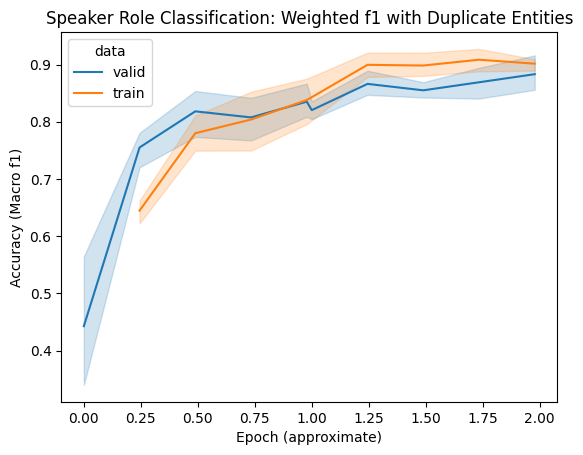

In [34]:
#TODO: collect different types of F1 scores, also do for no duplicates in validation set 
sns.lineplot(data=metricDf, x="epochFrac", y="f1", hue="data")
plt.ylabel("Accuracy (Macro f1)")
plt.xlabel("Epoch (approximate)")
plt.title("Speaker Role Classification: Weighted f1 with Duplicate Entities")

In [37]:
metricDf

,fold,step,epochFrac,epoch,f1,learningRate,data
0,0,0,0.000000,0,0.334820,1.105970,valid
1,0,100,0.244499,0,0.777416,0.798675,valid
2,0,200,0.488998,0,0.834680,0.736080,valid
3,0,300,0.733496,0,0.831384,0.722095,valid
4,0,0,1.000000,1,0.790631,0.742903,valid
...,...,...,...,...,...,...,...
31,4,400,0.977995,0,0.842431,0.787724,train
32,4,100,1.244499,1,0.906738,0.649787,train
33,4,200,1.488998,1,0.902764,0.651133,train
34,4,300,1.733496,1,0.919383,0.647179,train


In [42]:
fullDf = pd.DataFrame(allMetrics, columns=["lastPreds", "lastGts", "trainOutput", "validOutput"])

In [46]:
fullDf = fullDf.reset_index().rename(columns={"index":"fold"})